In [ ]:
!nvidia-smi

In [52]:
data_folder = '/media/QNAP/People/GongyuZhang/ROP/data/raw/image/'
import os
import csv
import json
from collections import Counter
from itertools import combinations

from PIL import Image
import numpy as np

from keras.applications import DenseNet201
from keras.models import Model
from keras.layers import MaxPool2D, Dense, Conv2D, Flatten, Softmax
from keras.optimizers import Adam

from sklearn.metrics import roc_auc_score
import batch_preparation


from matplotlib import pylab as plt
from IPython.display import clear_output


## Config

In [11]:
input_size = 512, 512

batch_size = 6
learning_rate = 1e-5

n_iterations_per_epoch = 100
n_epochs = 60

grading_labels = {
    'normal': [1,0,0],
    'preplus': [0,1,0],
    'plus': [0,0,1],
}
n_classes = len(grading_labels)

## Load data

In [12]:
with open('../src/data/data_split.csv', 'r') as f:
    split = list(csv.reader(f))
    header = split[0]
    data = split[1:]
    
len(data)

7414

In [13]:
header

['file', 'subset', 'CH', 'JT', 'KP', 'SB', 'GA', 'group']

In [14]:
Counter(d[-1] for d in data)

Counter({'normal': 6385, 'ungradable': 564, 'pre-plus': 235, 'plus': 230})

In [15]:
all_files = [d[0] for d in data]

In [16]:
len(all_files)

7414

In [18]:
# load all images into memory (takes a while)
all_data = {
    path: np.array(Image.open(os.path.join(data_folder, path)))[:,:,:3]
    for path in all_files
}

## Folds

In [53]:
fold_names = 'fold_0', 'fold_1', 'fold_2', 'fold_3', 'fold_4', 'test', 'exclude'

# {foldname: [(filename, grading), ...]}
# using group label (row[-1])
fold_files = {fold_name: [(row[0], row[-1]) for row in data if row[1] == fold_name]
             for fold_name in fold_names}

In [54]:
def get_grading_data(folds, grading_labels):
    
    # all files and gradings in folds
    files = [(path, grading) for fold_name, fold_items in fold_files.items()
                  for path, grading in fold_items if fold_name in folds]
    
    # map grading to list of raw images (np array)
    return {
        grading: [all_data[path] for path, g in files if grading == g]
        for grading in grading_labels
    }

def get_data(validation_fold, grading_labels):
    training_folds = {f for f in fold_names if f!= validation_fold and f!='test'}
    
    training_data = get_grading_data(training_folds, grading_labels)
    validation_data = get_grading_data((validation_fold, ), grading_labels)
    
    return training_data, validation_data

## Model

In [55]:
def get_model():
    
    base_model = DenseNet201(
        include_top=False,
        weights="imagenet",
        input_tensor=None,
        input_shape=(*input_size, n_classes),
        pooling=None,
    )

    l = MaxPool2D()(base_model.output)
    l = Conv2D(filters=512, kernel_size=(1, 1), activation='relu')(l)
    l = Flatten()(l)
    l = Dense(units=n_classes)(l)
    l = Softmax()(l)
    model = Model(base_model.input, l)
    
    optimizer = Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy')
    return model


## Validation

In [56]:
def avg_auc(scores, grading_labels):
    return np.mean([scores[k] for k in grading_labels])


def validate(model, grading_labels, data_set_preprocessed):
    
    n = len(data_set_preprocessed)
    yt = np.zeros((n, 3))
    yp = np.zeros((n, 3))
    
    for i, (grading, x) in enumerate(data_set_preprocessed):
        yt[i] = grading_labels[grading]
        yp[i] = model.predict_on_batch(x[np.newaxis])[0]
           
    scores = {}
    for name, labels in grading_labels.items():
        i = np.argmax(labels)
        try:
            scores[name] = roc_auc_score(yt[:,i], yp[:,i])
        except:
            scores[name] = np.nan
    
    scores['avg_auc'] = avg_auc(scores, grading_labels)
    
    correct = np.argmax(yt, axis=-1) == np.argmax(yp, axis=-1)
    scores['accuracy'] = np.count_nonzero(correct) / n

    return scores


## Training loop

In [57]:
def get_batches(validation_fold, grading_labels):
    training_data, validation_data = get_data(validation_fold, grading_labels)

    training_batch_preparation = batch_preparation.BatchPreparationClassBalanced(
        grading_labels, 
        training_data, 
        n_channels = 3, 
        batch_size = batch_size, 
    )

    validation_set_preprocessed = [(grading, batch_preparation.sample_patch(image, augment=False))
                                   for grading, images in validation_data.items() 
                                   for image in images]

    return training_batch_preparation, validation_set_preprocessed

In [61]:
def training_loop(validation_fold, grading_labels):
    
    model = get_model()
    
    training_batch_preparation, validation_set_preprocessed = get_batches(validation_fold, grading_labels)
    
    losses = []
    all_scores = {k:[] for k in grading_labels}
    all_scores['accuracy'] = []
    all_scores['avg_auc'] = []

    best_normal_auc = 0
    for epoch in range(n_epochs):
        for i in range(n_iterations_per_epoch):
            x, y = training_batch_preparation.get_batch()
            loss = model.train_on_batch(x, y)
            losses.append(loss)
           
        scores = validate(model, grading_labels, validation_set_preprocessed)
        
        if scores['normal'] > best_normal_auc:
            best_normal_auc = scores['normal']
            
            if epoch > 10:
                model.save('models/val_fold_{}_epoch_{}'.format(validation_fold, epoch))
        
        for k, v in scores.items():
            all_scores[k].append(v)
        
        
        display(losses, scores, all_scores, epoch)
        
    return model, losses, all_scores
        

def display(losses, scores, all_scores, epoch):
    
    clear_output()
    print(scores)    
    print('epoch: ', epoch)

    plt.plot(losses, label='loss')    
    plt.plot(np.convolve(losses, np.ones(20))/20, label='loss')    
    plt.legend()
    plt.show()

    for k, v in scores.items():
        plt.plot(all_scores[k], label=k)
    
    plt.legend()
    plt.show()
        
        

{'normal': 0.9974489795918368, 'preplus': nan, 'plus': 0.9974489795918366, 'avg_auc': nan, 'accuracy': 0.9916387959866221}
epoch:  32


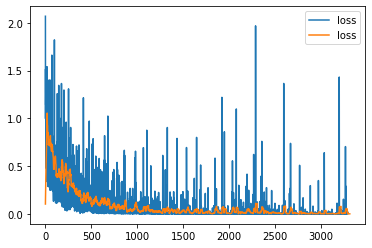

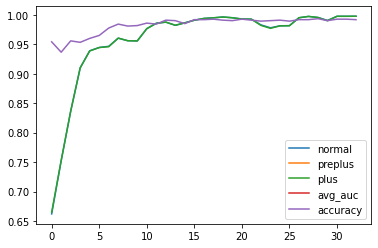

In [ ]:
for f in range(5):
    validation_fold = 'fold_{}'.format(f)
    export_file = 'scores_{}.json'.format(validation_fold)
    
    if os.path.exists(export_file):
        continue
        
    print('starting training loop', validation_fold)
    model, losses, all_scores = training_loop(validation_fold, grading_labels)
    with open(export_file, 'w') as f:
        json.dump({
            'losses': [float(l) for l in losses],
            'all_scores': all_scores
        }, f)

        
    